### Read the csv-files in one DataFrame: ###

In [1]:
# Import libraries
import pandas as pd
import math
import numpy as np
import zipfile

# Import libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set end date for data analysis
from datetime import datetime

# Don't show warnings
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
# Read annual csv-files with cleaned bike-trips from zip-file:
# CAUTION: Script runs several minutes!!
df = pd.DataFrame
zf = zipfile.ZipFile('data/trips.zip')
trips_list = []

# Create list with csv files in trips.zip
for i in range(0,len(zipfile.ZipFile.namelist(zf))):
    if not (zipfile.ZipFile.namelist(zf)[i].startswith('__MACOSX')):
        trips_list.append(zipfile.ZipFile.namelist(zf)[i])
trips_list.sort()

# Read all csv-files and concatenate into one DataFrame
for i in trips_list:
    if (i == 'trips_2013.csv'):
        df = pd.read_csv(zf.open(i), dtype={'bikeid': 'Int64'}, low_memory=False)
    else:
        df_temp = pd.read_csv(zf.open(i), dtype={'bikeid': 'Int64'}, low_memory=False)
        df = pd.concat([df, df_temp])
        del df_temp

# Cleanup DataFrame
df.drop(columns=['Unnamed: 0'], inplace=True)
df['starttime'] = pd.to_datetime(df['starttime'], yearfirst=True)
df['rideable_type'].fillna('docked_bike', inplace=True)
df.reset_index(drop=True, inplace=True)

# Show content of DataFrame
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38420479 entries, 0 to 38420478
Data columns (total 11 columns):
 #   Column               Non-Null Count     Dtype         
---  ------               --------------     -----         
 0   starttime            38420479 non-null  datetime64[ns]
 1   tripduration_in_min  38420479 non-null  float64       
 2   start_station_name   36353290 non-null  object        
 3   start_station_lat    38239547 non-null  float64       
 4   start_station_lon    38239547 non-null  float64       
 5   end_station_name     36216128 non-null  object        
 6   end_station_lat      38214476 non-null  float64       
 7   end_station_lon      38214476 non-null  float64       
 8   customer             38420479 non-null  object        
 9   bikeid               21123295 non-null  Int64         
 10  rideable_type        38420479 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(5), object(4)
memory usage: 3.2+ GB


### Create DataFrame with monthly trips and bikeid's: ###

In [3]:
# Create new DataFrame, starting from 2013-07-01
df_trips = df[(df['starttime']>= '2013-07-01')][['starttime', 'bikeid']]
df_trips.reset_index(drop=True, inplace=True)
# Level all dates to first day of the month
df_trips['year'] = df_trips.loc[:,'starttime'].dt.year
df_trips['month'] = df_trips.loc[:,'starttime'].dt.month
df_trips['day'] = 1
df_trips['datetime'] = pd.to_datetime(df_trips[['year', 'month', 'day']], format='%Y-%m-%d')
df_trips = df_trips[['datetime', 'starttime', 'bikeid']]
# Aggregate data for whole months
df_count = df_trips.groupby(['datetime']).agg(['count', 'nunique'])
# Selecting necessary data and renaming columns
df_count.reset_index(drop=False, inplace=True)
df_trips = df_count.iloc[:, [0,1,4]]
del df_count
df_trips.columns = df_trips.columns.to_flat_index()
df_trips.columns = ['datetime','rides_count','bike_id']
df_trips.info(show_counts=True)
df_trips

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     125 non-null    datetime64[ns]
 1   rides_count  125 non-null    int64         
 2   bike_id      125 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 3.1 KB


,datetime,rides_count,bike_id
0,2013-07-01,74648,985
1,2013-08-01,170017,1739
2,2013-09-01,200444,2443
3,2013-10-01,174187,2750
4,2013-11-01,89682,2469
...,...,...,...
120,2023-07-01,633813,0
121,2023-08-01,637555,0
122,2023-09-01,549791,0
123,2023-10-01,436288,0


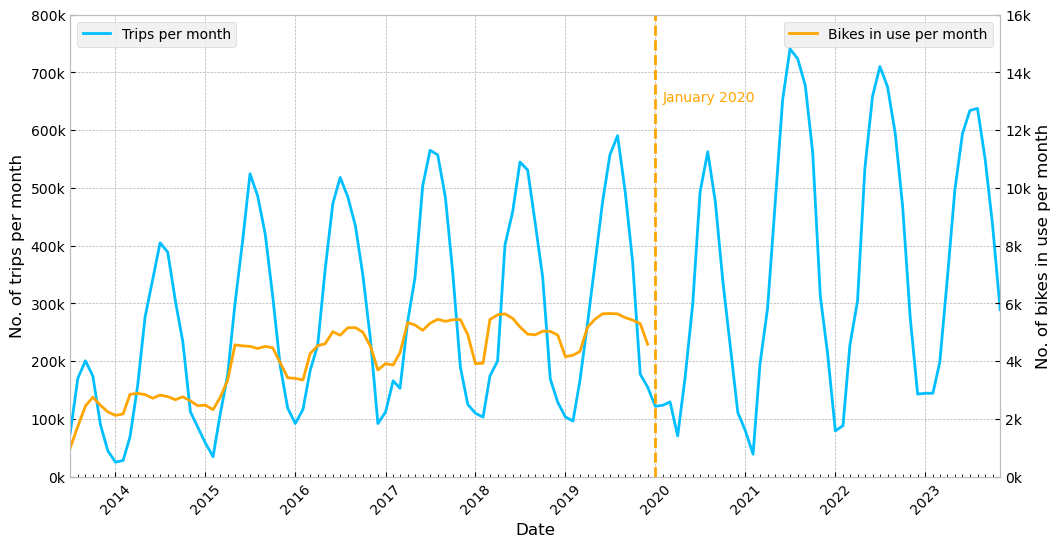

In [4]:
# Plot above DataFrame
plt.style.use('bmh')
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_facecolor('white')
# Set rides_count for main axis
rides_count = ax1.plot(df_trips['datetime'], df_trips['rides_count'], color='deepskyblue')
ax1.set_ylabel('No. of trips per month')
# Set rides_count y-axis according to values in 100000 rides intervals
rides_max = (math.ceil(df_trips['rides_count'].max()) // 100000 + 1) * 100000
ax1.set_ylim(0, rides_max)
ax1.set_yticklabels(['{:,.0f}'.format(rides_max) + 'k' for rides_max in ax1.get_yticks()/1000])

# Set datetime x-axis with day intervals
ax1.set_xlabel('Date')
ax1.set_xlim(df_trips['datetime'].min(), df_trips['datetime'].max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.legend(['Trips per month'], loc="upper left")
plt.xticks(rotation=45, fontweight='light')
plt.annotate("January 2020", (pd.Timestamp('2020-02-01'), 650000), color='orange')

# Set secondary y-axis with unique bike +id's
ax2 = ax1.twinx()
ax2.set_ylabel('No. of bikes in use per month')
# Set bikeid y-axis according to values in 1000 bike intervals
#bikes_max = (math.ceil(df_trips['bike_id'].max()) // 10000 + 1) * 10000
bikes_max = 16000
ax2.set_ylim(0, bikes_max)
ax2.set_yticklabels(['{:,.0f}'.format(bikes_max) + 'k' for bikes_max in ax2.get_yticks()/1000])
bikesid = ax2.plot(df_trips['datetime'][df_trips['datetime'] < '2020-01-01'], df_trips['bike_id'][df_trips['datetime'] < '2020-01-01'], color='orange')
ax2.legend(['Bikes in use per month'], loc="upper right")
ax2.axvline(pd.Timestamp('2020-01-01'), color='orange', linestyle='--')
ax2.grid(False)

# Show diagram
plt.show();

### Create DataFrame with 'classic_bike' and 'electric_bike' count: ###

In [5]:
# Create new DataFrame, starting from 2013-07-01
df_types = df[(df['starttime']>= '2013-07-01')][['starttime', 'rideable_type']]
df_types.reset_index(drop=True, inplace=True)
# Level all dates to first day of the month
df_types['year'] = df_types.loc[:,'starttime'].dt.year
df_types['month'] = df_types.loc[:,'starttime'].dt.month
df_types['day'] = 1
df_types['datetime'] = pd.to_datetime(df_types[['year', 'month', 'day']], format='%Y-%m-%d')
df_types = df_types[['datetime', 'starttime', 'rideable_type']]
# Create columns with classic and electric bikes
df_types['classic'] = np.where(df_types['rideable_type'] != 'electric_bike', 1, 0)
df_types['electric'] = np.where(df_types['rideable_type'] == 'electric_bike', 1, 0)
# Aggregate data for whole months
df_sum = df_types.groupby(['datetime'])[['classic', 'electric']].sum()
df_sum.reset_index(drop=False, inplace=True)
df_types = df_sum
del df_sum
df_types.info(show_counts=True)
df_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  125 non-null    datetime64[ns]
 1   classic   125 non-null    int32         
 2   electric  125 non-null    int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 2.1 KB


,datetime,classic,electric
0,2013-07-01,74648,0
1,2013-08-01,170017,0
2,2013-09-01,200444,0
3,2013-10-01,174187,0
4,2013-11-01,89682,0
...,...,...,...
120,2023-07-01,312656,321157
121,2023-08-01,342017,295538
122,2023-09-01,286263,263528
123,2023-10-01,219387,216901


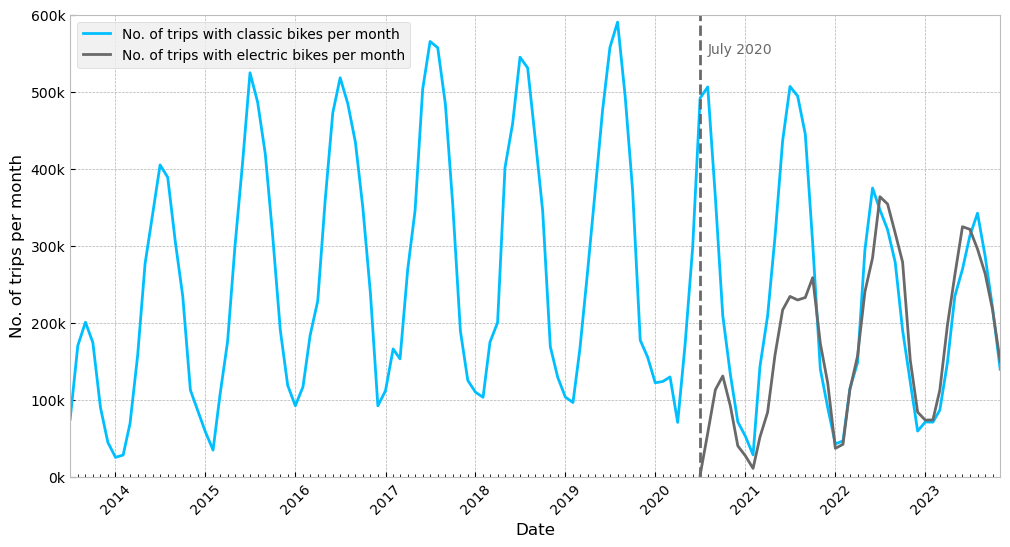

In [6]:
# Plot above DataFrame
plt.style.use('bmh')
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_facecolor('white')
# Set rides_count for main axis
classic_sum = ax1.plot(df_types['datetime'], df_types['classic'], color='deepskyblue')
electric_sum = ax1.plot(df_types['datetime'][df_types['datetime'] > '2020-06-01'], df_types['electric'][df_types['datetime'] > '2020-06-01'], color='dimgrey')
ax1.set_ylabel('No. of trips per month')
# Set rides_count y-axis according to values in 100000 rides intervals
if df_types['classic'].max() >= df_types['electric'].max():
    bikes_max = (math.ceil(df_types['classic'].max()) // 100000 + 1) * 100000
else:
    bikes_max = (math.ceil(df_types['electric'].max()) // 100000 + 1) * 100000
ax1.set_ylim(0, bikes_max)
ax1.set_yticklabels(['{:,.0f}'.format(bikes_max) + 'k' for bikes_max in ax1.get_yticks()/1000])
# Set datetime x-axis with day intervals
ax1.set_xlabel('Date')
ax1.set_xlim(df_types['datetime'].min(), df_types['datetime'].max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.legend(['No. of trips with classic bikes per month', 'No. of trips with electric bikes per month'], loc="upper left")
plt.xticks(rotation=45, fontweight='light')

# Add vertical line to show when electric bikes started
ax1.axvline(pd.Timestamp('2020-07-01'), color='dimgrey', linestyle='--')
plt.annotate("July 2020", (pd.Timestamp('2020-08-01'), 550000), color='dimgrey')

# Show diagram
plt.show();

### Create DataFrame with average tripdurations: ###

Tripdurations less than one minute and greater than six hours are excluded!

In [7]:
# Create new DataFrame, starting from 2013-07-01 and with tripdurations <= 6 hours
df_duration = df[(df['starttime']>= '2013-07-01') & (df['tripduration_in_min'] <= 360)][['starttime', 'tripduration_in_min', 'rideable_type']]
df_duration.reset_index(drop=True, inplace=True)
# Level all dates to first day of the month
df_duration['year'] = df_duration.loc[:,'starttime'].dt.year
df_duration['month'] = df_duration.loc[:,'starttime'].dt.month
df_duration['day'] = 1
df_duration['datetime'] = pd.to_datetime(df_duration[['year', 'month', 'day']], format='%Y-%m-%d')
df_duration = df_duration[['datetime', 'starttime', 'tripduration_in_min', 'rideable_type']]
# Create columns with classic and electric bikes
df_duration['classic'] = np.where(df_duration['rideable_type'] != 'electric_bike', 1, 0)
# Aggregate data for whole months
df_avg = df_duration.groupby(['datetime', 'classic'])[['tripduration_in_min']].mean()
df_final = df_duration.groupby(['datetime'])
df_avg.reset_index(drop=False, inplace=True)
# Build new DataFrame with average tripdurations for classic and electric bikes
df_final = df_avg[df_avg['classic'] == 1].copy()
df_final.reset_index(drop=True, inplace=True)
df_final.drop(columns=['classic'], inplace=True)
df_final.rename(columns={'tripduration_in_min': 'classic_tripduration'}, inplace=True)
df_final['classic_tripduration'] = round(df_final['classic_tripduration'], 2)
df_test = df_final.merge(df_avg[df_avg['classic'] == 0], how='left', on='datetime')
df_test.drop(columns=['classic'], inplace=True)
df_test.rename(columns={'tripduration_in_min': 'electric_tripduration'}, inplace=True)
df_test['electric_tripduration'] = round(df_test['electric_tripduration'], 2)
df_duration = df_test
del df_final
del df_test
del df_avg
df_duration.info(show_counts=True)
df_duration

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   datetime               125 non-null    datetime64[ns]
 1   classic_tripduration   125 non-null    float64       
 2   electric_tripduration  41 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.9 KB


,datetime,classic_tripduration,electric_tripduration
0,2013-07-01,26.29,NaN
1,2013-08-01,22.77,NaN
2,2013-09-01,19.77,NaN
3,2013-10-01,16.17,NaN
4,2013-11-01,12.75,NaN
...,...,...,...
120,2023-07-01,19.56,14.21
121,2023-08-01,18.23,13.63
122,2023-09-01,17.73,13.30
123,2023-10-01,15.36,11.71


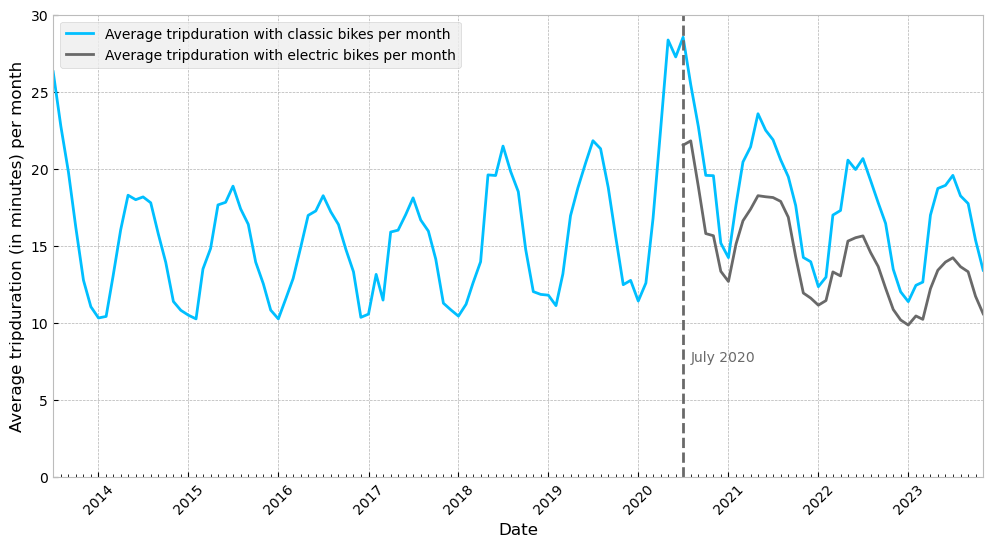

In [8]:
# Plot above DataFrame
plt.style.use('bmh')
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_facecolor('white')
# Set rides_count for main axis
classic_avg = ax1.plot(df_duration['datetime'], df_duration['classic_tripduration'], color='deepskyblue')
electric_sum = ax1.plot(df_duration['datetime'][df_duration['datetime'] > '2020-06-01'], df_duration['electric_tripduration'][df_duration['datetime'] > '2020-06-01'], color='dimgrey')
ax1.set_ylabel('Average tripduration (in minutes) per month')
# Set rides_count y-axis according to values in 100000 rides intervals
if df_duration['classic_tripduration'].max() >= df_duration['electric_tripduration'].max():
    duration_max = (math.ceil(df_duration['classic_tripduration'].max()) // 10 + 1) * 10
else:
    duration_max = (math.ceil(df_duration['electric_tripduration'].max()) // 10 + 1) * 10
ax1.set_ylim(0, duration_max)
# Set datetime x-axis with day intervals
ax1.set_xlabel('Date')
ax1.set_xlim(df_duration['datetime'].min(), df_duration['datetime'].max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.legend(['Average tripduration with classic bikes per month', 'Average tripduration with electric bikes per month'], loc="upper left")
plt.xticks(rotation=45, fontweight='light')

# Add vertical line to show when electric bikes started
ax1.axvline(pd.Timestamp('2020-07-01'), color='dimgrey', linestyle='--')
plt.annotate("July 2020", (pd.Timestamp('2020-08-01'), 7.5), color='dimgrey')

# Show diagram
plt.show();

### Create DataFrame with customers / members : ###

In [9]:
# Create new DataFrame, starting from 2013-07-01 and with tripdurations <= 6 hours
df_customer = df[(df['starttime']>= '2013-07-01')][['starttime', 'customer']]
df_customer.reset_index(drop=True, inplace=True)
# Level all dates to first day of the month
df_customer['year'] = df_customer.loc[:,'starttime'].dt.year
df_customer['month'] = df_customer.loc[:,'starttime'].dt.month
df_customer['day'] = 1
df_customer['datetime'] = pd.to_datetime(df_customer[['year', 'month', 'day']], format='%Y-%m-%d')
df_customer = df_customer[['datetime', 'starttime', 'customer']]
# Create columns with casual and member customers
df_customer['casual'] = np.where(df_customer['customer'] == 'casual', 1, 0)
df_customer['member'] = np.where(df_customer['customer'] == 'member', 1, 0)
# Aggregate data for whole months
df_sum = df_customer.groupby(['datetime'])[['casual', 'member']].sum()
df_sum.reset_index(drop=False, inplace=True)
df_customer = df_sum
del df_sum
df_customer.info(show_counts=True)
df_customer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  125 non-null    datetime64[ns]
 1   casual    125 non-null    int32         
 2   member    125 non-null    int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 2.1 KB


,datetime,casual,member
0,2013-07-01,51451,23197
1,2013-08-01,109872,60145
2,2013-09-01,105084,95360
3,2013-10-01,64063,110124
4,2013-11-01,18028,71654
...,...,...,...
120,2023-07-01,274513,359300
121,2023-08-01,257541,380014
122,2023-09-01,216314,333477
123,2023-10-01,143178,293110


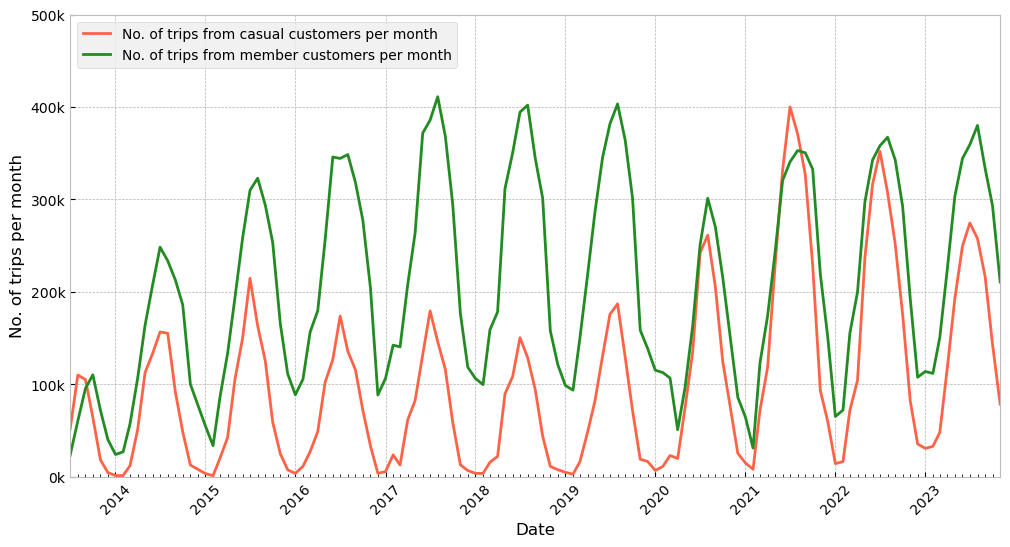

In [10]:
# Plot above DataFrame
plt.style.use('bmh')
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_facecolor('white')
# Set rides_count for main axis
casual_sum = ax1.plot(df_customer['datetime'], df_customer['casual'], color='tomato')
member_sum = ax1.plot(df_customer['datetime'], df_customer['member'], color='forestgreen')
ax1.set_ylabel('No. of trips per month')
# Set rides_count y-axis according to values in 100000 rides intervals
if df_customer['casual'].max() >= df_customer['member'].max():
    customer_max = (math.ceil(df_customer['casual'].max()) // 100000 + 1) * 100000
else:
    customer_max = (math.ceil(df_customer['member'].max()) // 100000 + 1) * 100000
ax1.set_ylim(0, customer_max)
ax1.set_yticklabels(['{:,.0f}'.format(customer_max) + 'k' for customer_max in ax1.get_yticks()/1000])
# Set datetime x-axis with day intervals
ax1.set_xlabel('Date')
ax1.set_xlim(df_customer['datetime'].min(), df_customer['datetime'].max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.legend(['No. of trips from casual customers per month', 'No. of trips from member customers per month'], loc="upper left")
plt.xticks(rotation=45, fontweight='light')

# Show diagram
plt.show();

### Add cost_of_trip as new column to DataFrame for trips after 2020: ###
The costs are calculated on the basis of the costs in summer 2023. This is only an estimation for the whole period of time and doesn't reflect the real costs!

In [ ]:
# CAUTION: Script runs several minutes!!
df_money = df[(df['starttime']>= '2020-01-01') & (df['tripduration_in_min'] <= 360)][['starttime', 'tripduration_in_min', 'customer', 'rideable_type']]
df_money.reset_index(drop=True, inplace=True)
df_money['cost_of_trip'] = 0.0
# Calculate costs per trip for different customers
for i, row in df_money.iterrows():
    # Member, classic bike, tripduration > 45 minutes
    if (row['customer'] == 'member') and (row['rideable_type'] == 'classic_bike' or row['rideable_type'] == 'docked_bike') and (row['tripduration_in_min'] > 45):
        df_money.at[i,'cost_of_trip'] = np.ceil(df_money.at[i,'tripduration_in_min'] - 45) * 0.17
    # Member, electric bike
    elif (row['customer'] == 'member') and (row['rideable_type'] == 'electric_bike'):
        df_money.at[i,'cost_of_trip'] = np.ceil(df_money.at[i,'tripduration_in_min']) * 0.17
    # Casual, classic bike
    elif (row['customer'] == 'casual') and (row['rideable_type'] == 'classic_bike' or row['rideable_type'] == 'docked_bike'):
        df_money.at[i,'cost_of_trip'] = 1.0 + np.ceil(df_money.at[i,'tripduration_in_min']) * 0.17
    # Casual, electric bike
    elif (row['customer'] == 'casual') and (row['rideable_type'] == 'electric_bike'):
        df_money.at[i,'cost_of_trip'] = 1.0 + (np.ceil(df_money.at[i,'tripduration_in_min']) * 0.42)
# Sort out all trips without costs
df_temp = df_money[df_money['cost_of_trip'] > 0.0]
df_temp.reset_index(drop=True, inplace=True)
df_money = df_temp
del df_temp
df_money.info(show_counts=True)
# Save DataFrame to csv-file
df_money.to_csv('data/trips_with_costs.csv', index=False)

In [ ]:
# Re-read the csv-file which was saved in the above code-box:
df_money = pd.read_csv('data/trips_with_costs.csv')
df_money['starttime'] = pd.to_datetime(df_money['starttime'], yearfirst=True)
df_money.info(show_counts=True)

In [ ]:
# Level all dates to first day of the month
df_money['year'] = df_money.loc[:,'starttime'].dt.year
df_money['month'] = df_money.loc[:,'starttime'].dt.month
df_money['day'] = 1
df_money['datetime'] = pd.to_datetime(df_money[['year', 'month', 'day']], format='%Y-%m-%d')
df_money = df_money[['datetime', 'tripduration_in_min', 'customer', 'rideable_type', 'cost_of_trip']]
df_money.info(show_counts=True)

In [ ]:
df_cost_customer = df_money
# Create columns with classic and electric bikes
df_cost_customer['casual'] = np.where(df_cost_customer['customer'] == 'casual', 1, 0)
# Aggregate data for whole months
df_sum = df_cost_customer.groupby(['datetime', 'casual'])[['cost_of_trip']].sum()
df_sum.reset_index(drop=False, inplace=True)
# Build new DataFrame with average tripdurations for classic and electric bikes
df_final = df_money.groupby(['datetime'])
df_final = df_sum[df_sum['casual'] == 1].copy()
df_final
df_final.reset_index(drop=True, inplace=True)
df_final.drop(columns=['casual'], inplace=True)
df_final.rename(columns={'cost_of_trip': 'casual_cost'}, inplace=True)
#df_final['classic_tripduration'] = round(df_final['classic_tripduration'], 2)
df_test = df_final.merge(df_sum[df_sum['casual'] == 0], how='left', on='datetime')
df_test.drop(columns=['casual'], inplace=True)
df_test.rename(columns={'cost_of_trip': 'member_cost'}, inplace=True)
# df_test['electric_tripduration'] = round(df_test['electric_tripduration'], 2)
df_cost_customer = df_test
del df_final
del df_test
del df_sum
df_cost_customer.info(show_counts=True)
df_cost_customer

In [ ]:
# Plot above DataFrame
plt.style.use('bmh')
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_facecolor('white')
# Set rides_count for main axis
casual_cost = ax1.plot(df_cost_customer['datetime'], df_cost_customer['casual_cost'], color='tomato')
member_cost = ax1.plot(df_cost_customer['datetime'], df_cost_customer['member_cost'], color='forestgreen')
ax1.set_ylabel('Trip costs (in $MM) per month')
# Set rides_count y-axis according to values in 100000 rides intervals
if df_cost_customer['casual_cost'].max() >= df_cost_customer['member_cost'].max():
    cost_max = (math.ceil(df_cost_customer['casual_cost'].max()) // 100000 + 1) * 100000
else:
    cost_max = (math.ceil(df_cost_customer['member_cost'].max()) // 100000 + 1) * 100000
ax1.set_ylim(0, cost_max)
ax1.set_yticklabels(['$' + '{:,.1f}'.format(cost_max) + 'MM' for cost_max in ax1.get_yticks()/1000000])
# Set datetime x-axis with day intervals
ax1.set_xlabel('Date')
ax1.set_xlim(df_cost_customer['datetime'].min(), df_cost_customer['datetime'].max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.legend(['Trip costs by casual customers per month', 'Trip costs by member customers per month'], loc="upper left")
plt.xticks(rotation=45, fontweight='light')

# Show diagram
plt.show();

### Trip costs by classic / electric bikes: ###

In [ ]:
df_cost_biketype = df_money
# Create columns with classic and electric bikes
df_cost_biketype['classic'] = np.where(df_cost_biketype['rideable_type'] != 'electric_bike', 1, 0)
# Aggregate data for whole months
df_sum = df_cost_biketype.groupby(['datetime', 'classic'])[['cost_of_trip']].sum()
df_sum.reset_index(drop=False, inplace=True)
# Build new DataFrame with average tripdurations for classic and electric bikes
df_final = df_money.groupby(['datetime'])
df_final = df_sum[df_sum['classic'] == 1].copy()
df_final
df_final.reset_index(drop=True, inplace=True)
df_final.drop(columns=['classic'], inplace=True)
df_final.rename(columns={'cost_of_trip': 'classic_cost'}, inplace=True)
df_test = df_final.merge(df_sum[df_sum['classic'] == 0], how='left', on='datetime')
df_test.drop(columns=['classic'], inplace=True)
df_test.rename(columns={'cost_of_trip': 'electric_cost'}, inplace=True)
df_cost_biketype = df_test
del df_final
del df_test
del df_sum
df_cost_biketype.info(show_counts=True)
df_cost_biketype

In [ ]:
# Plot above DataFrame
plt.style.use('bmh')
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_facecolor('white')
# Set rides_count for main axis
classic_cost = ax1.plot(df_cost_biketype['datetime'], df_cost_biketype['classic_cost'], color='deepskyblue')
electric_cost = ax1.plot(df_cost_biketype['datetime'][df_cost_biketype['datetime'] > '2020-06-01'], df_cost_biketype['electric_cost'][df_cost_biketype['datetime'] > '2020-06-01'], color='dimgrey')
ax1.set_ylabel('Trip costs (in $MM) per month')
# Set rides_count y-axis according to values in 100000 rides intervals
if df_cost_biketype['classic_cost'].max() >= df_cost_biketype['electric_cost'].max():
    cost_max = (math.ceil(df_cost_biketype['classic_cost'].max()) // 250000 + 1) * 250000
else:
    cost_max = (math.ceil(df_cost_biketype['electric_cost'].max()) // 250000 + 1) * 250000
ax1.set_ylim(0, cost_max)
ax1.set_yticklabels(['$' + '{:,.2f}'.format(cost_max) + 'MM' for cost_max in ax1.get_yticks()/1000000])
# Set datetime x-axis with day intervals
ax1.set_xlabel('Date')
ax1.set_xlim(df_cost_biketype['datetime'].min(), df_cost_biketype['datetime'].max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.legend(['Trip costs by classic bikes per month', 'Trip costs by electric bikes per month'], loc="upper center")
plt.xticks(rotation=45, fontweight='light')

# Add vertical line to show when electric bikes started
ax1.axvline(pd.Timestamp('2020-07-01'), color='dimgrey', linestyle='--')
plt.annotate("July 2020", (pd.Timestamp('2020-07-15'), 2100000), color='dimgrey')

# Show diagram
plt.show();

### Correlation of trips & temperature: ###

In [11]:
# Create weather DataFrame
df_weather = pd.read_csv('data/chicago_weather.csv')
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather = df_weather[(df_weather['datetime'] >= '2013-07-01 00:00')]
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91328 entries, 96 to 91423
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         91328 non-null  datetime64[ns]
 1   temp             91328 non-null  float64       
 2   rain_1h          91328 non-null  float64       
 3   snow_1h          91328 non-null  float64       
 4   wind_speed_km_h  91328 non-null  float64       
 5   wind_deg         91328 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 4.9 MB


In [12]:
# Merge df_trips with df_weather
df_test = df_weather[['datetime', 'temp']].copy()
df_test['year'] = df_test.loc[:,'datetime'].dt.year
df_test['month'] = df_test.loc[:,'datetime'].dt.month
df_test['day'] = 1
df_test['datetime_neu'] = pd.to_datetime(df_test[['year', 'month', 'day']], format='%Y-%m-%d')
df_temp = df_test.groupby(['datetime_neu'])[['temp']].mean()
del df_test
df_temp
df_temp.reset_index(drop=False, inplace=True)
df_temp.rename(columns={'datetime_neu': 'datetime'}, inplace=True)
df_temp['temp'] = round(df_temp['temp'], 2)
df_temp
df_w_trips = df_trips.merge(df_temp, how='left', on='datetime')
df_w_trips.drop(columns=['bike_id'], inplace=True)
df_w_trips.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     125 non-null    datetime64[ns]
 1   rides_count  125 non-null    int64         
 2   temp         125 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 3.9 KB


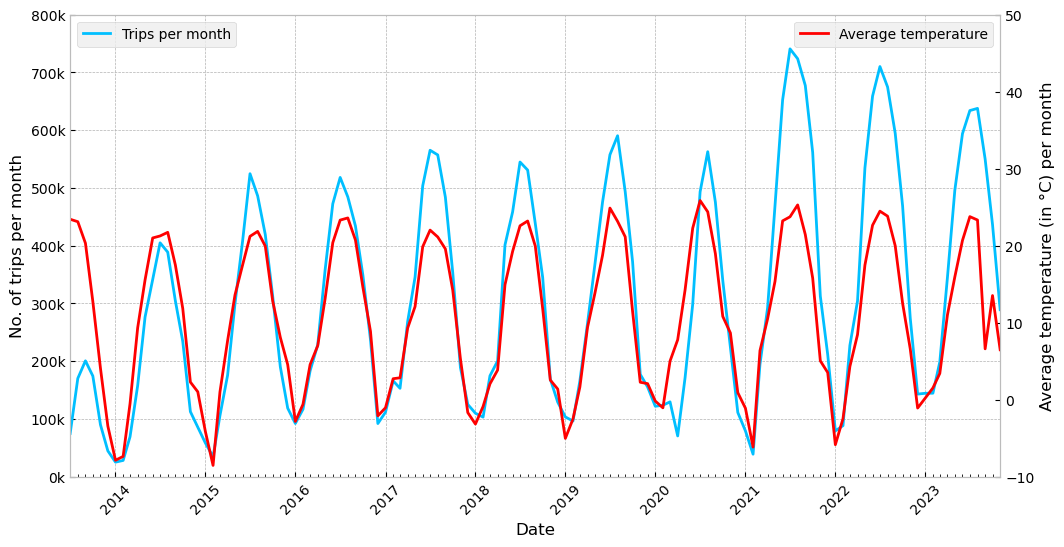

In [13]:
# Plot above DataFrame
plt.style.use('bmh')
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_facecolor('white')
# Set rides_count for main axis
rides_count = ax1.plot(df_w_trips['datetime'], df_w_trips['rides_count'], color='deepskyblue')
ax1.set_ylabel('No. of trips per month')
# Set rides_count y-axis according to values in 100000 rides intervals
rides_max = (math.ceil(df_w_trips['rides_count'].max()) // 100000 + 1) * 100000
ax1.set_ylim(0, rides_max)
ax1.set_yticklabels(['{:,.0f}'.format(rides_max) + 'k' for rides_max in ax1.get_yticks()/1000])

# Set datetime x-axis with day intervals
ax1.set_xlabel('Date')
ax1.set_xlim(df_w_trips['datetime'].min(), df_w_trips['datetime'].max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.legend(['Trips per month'], loc="upper left")
plt.xticks(rotation=45, fontweight='light')

# Set secondary y-axis with unique bike +id's
ax2 = ax1.twinx()
ax2.set_ylabel('Average temperature (in °C) per month')
# Set temp y-axis according to minimum and maximum
ax2.set_ylim(-10, 50)
temperature = ax2.plot(df_w_trips['datetime'], df_w_trips['temp'], color='red')
ax2.legend(['Average temperature'], loc="upper right")
ax2.grid(False)

# Show diagram
plt.show();

### Repetitive Divvy-user behaviour in week (2022-06-13 until 2022-06-19): ###

In [14]:
# Merge df_trips with df_weather
df_repeat = df[(df['starttime'] >= '2022-06-13 00:00:00') & (df['starttime'] < '2022-06-20 00:00:00')][['starttime']]
df_repeat.reset_index(drop=True, inplace=True)
df_repeat['year'] = df_repeat.loc[:,'starttime'].dt.year
df_repeat['month'] = df_repeat.loc[:,'starttime'].dt.month
df_repeat['day'] = df_repeat.loc[:,'starttime'].dt.day
df_repeat['hour'] = df_repeat.loc[:,'starttime'].dt.hour
df_repeat['datetime'] = pd.to_datetime(df_repeat[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00')
df_temp = df_repeat.groupby(['datetime'])[['starttime']].count()
df_temp.reset_index(drop=False, inplace=True)
df_temp.rename(columns={'starttime': 'rides_count'}, inplace=True)
df_repeat = df_temp
del df_temp
df_repeat.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     168 non-null    datetime64[ns]
 1   rides_count  168 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


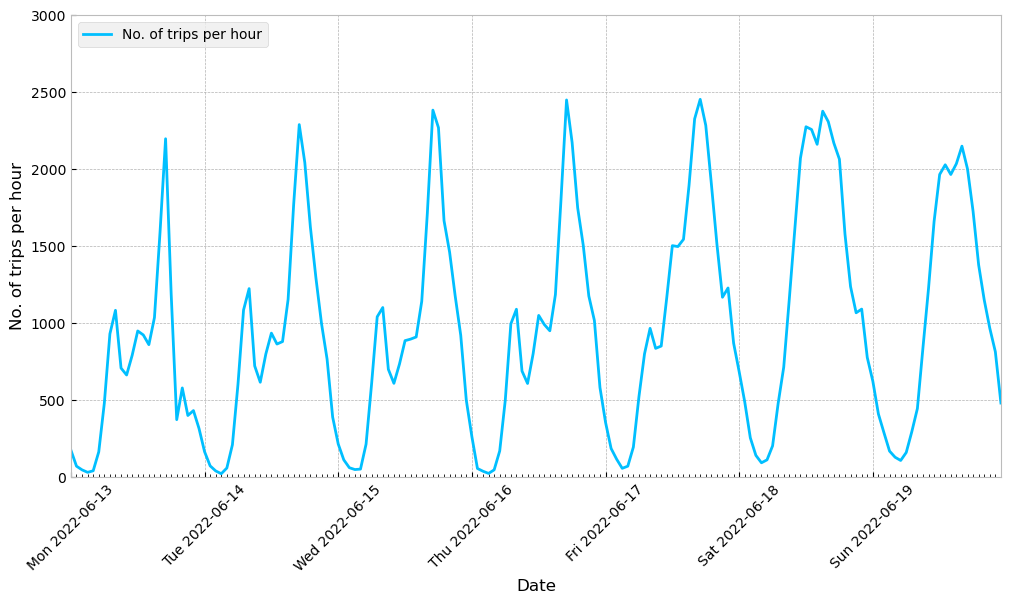

In [15]:
# Plot above DataFrame
plt.style.use('bmh')
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_facecolor('white')
# Set rides_count for main axis
rides_count = ax1.plot(df_repeat['datetime'], df_repeat['rides_count'], color='deepskyblue')
ax1.set_ylabel('No. of trips per hour')
# Set rides_count y-axis according to values in 1000 rides intervals
rides_max = (math.ceil(df_repeat['rides_count'].max()) // 1000 + 1) * 1000
ax1.set_ylim(0, rides_max)
# Set datetime x-axis with day intervals
ax1.set_xlabel('Date')
ax1.set_xlim(df_repeat['datetime'].min(), df_repeat['datetime'].max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%a %Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.xaxis.set_minor_locator(mdates.HourLocator())
ax1.legend(['No. of trips per hour'], loc="upper left")
plt.xticks(rotation=45, fontweight='light')

# Show diagram
plt.show();

### Repetitive Divvy-user behaviour in week (2022-07-11 until 2022-07-18) including rain: ###

In [16]:
# Merge df_trips with df_weather
df_repeat = df[(df['starttime'] >= '2022-07-11 00:00:00') & (df['starttime'] < '2022-07-18 00:00:00')][['starttime']]
df_repeat.reset_index(drop=True, inplace=True)
df_repeat['year'] = df_repeat.loc[:,'starttime'].dt.year
df_repeat['month'] = df_repeat.loc[:,'starttime'].dt.month
df_repeat['day'] = df_repeat.loc[:,'starttime'].dt.day
df_repeat['hour'] = df_repeat.loc[:,'starttime'].dt.hour
df_repeat['datetime'] = pd.to_datetime(df_repeat[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00')
df_temp = df_repeat.groupby(['datetime'])[['starttime']].count()
df_temp.reset_index(drop=False, inplace=True)
df_temp.rename(columns={'starttime': 'rides_count'}, inplace=True)
df_repeat = df_temp
del df_temp
# Merge df_trips with df_weather
df_test = df_weather[(df_weather['datetime'] >= '2022-07-11 00:00:00') & (df_weather['datetime'] < '2022-07-18 00:00:00')][['datetime', 'rain_1h']]
df_temp = df_repeat.merge(df_test, how='left', on='datetime')
del df_test
df_temp.reset_index(drop=True, inplace=True)
df_temp.info(show_counts=True)
df_temp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     168 non-null    datetime64[ns]
 1   rides_count  168 non-null    int64         
 2   rain_1h      168 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.1 KB


,datetime,rides_count,rain_1h
0,2022-07-11 00:00:00,194,0.00
1,2022-07-11 01:00:00,85,0.00
2,2022-07-11 02:00:00,64,0.00
3,2022-07-11 03:00:00,51,0.00
4,2022-07-11 04:00:00,66,0.00
...,...,...,...
163,2022-07-17 19:00:00,1027,0.76
164,2022-07-17 20:00:00,883,0.00
165,2022-07-17 21:00:00,736,0.00
166,2022-07-17 22:00:00,626,0.00


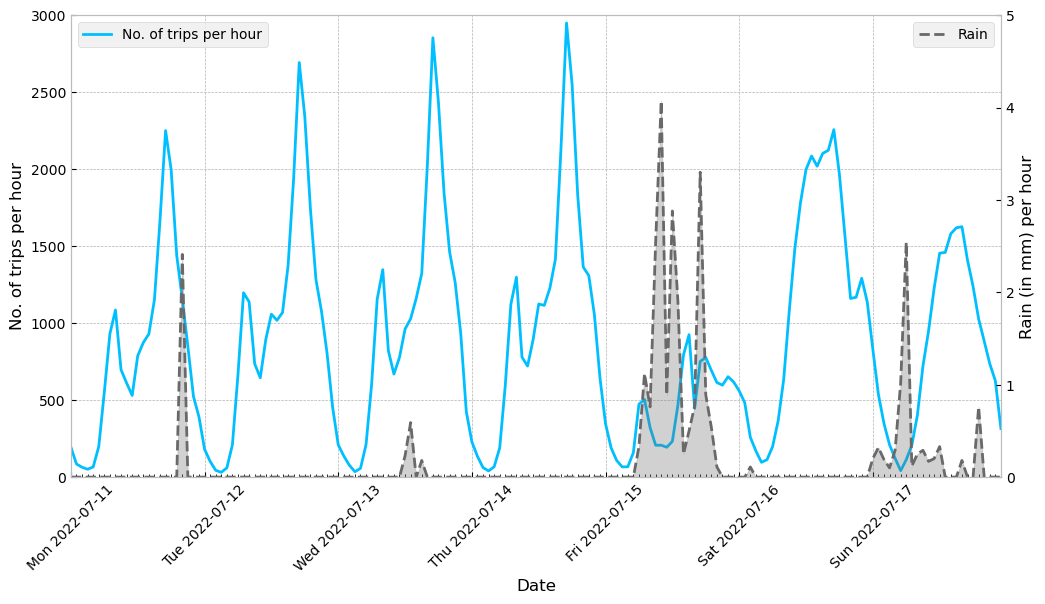

In [17]:
# Plot above DataFrame
plt.style.use('bmh')
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_facecolor('white')
# Set rides_count for main axis
rides_count = ax1.plot(df_temp['datetime'], df_temp['rides_count'], color='deepskyblue')
ax1.set_ylabel('No. of trips per hour')
# Set rides_count y-axis according to values in 100000 rides intervals
rides_max = (math.ceil(df_temp['rides_count'].max()) // 1000 + 1) * 1000
ax1.set_ylim(0, rides_max)
# Set datetime x-axis with day intervals
ax1.set_xlabel('Date')
ax1.set_xlim(df_temp['datetime'].min(), df_temp['datetime'].max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%a %Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.xaxis.set_minor_locator(mdates.HourLocator())
ax1.legend(['No. of trips per hour'], loc="upper left")
plt.xticks(rotation=45, fontweight='light')

# Set secondary y-axis with unique bike +id's
ax2 = ax1.twinx()
ax2.set_ylabel('Rain (in mm) per hour')#, color='white')
# Set temp y-axis according to minimum and maximum
ax2.set_ylim(0, 5)
rain = ax2.plot(df_temp['datetime'], df_temp['rain_1h'], linestyle='--', color='dimgrey')
ax2.legend(['Rain'], loc="upper right")
#ax2.set_yticks([1,2,3,4,5], labels=[1,2,3,4,5], color='white')
#ax2.tick_params(colors='white')
ax2.grid(False)
plt.fill_between(df_temp['datetime'], df_temp['rain_1h'], color='dimgrey', alpha=0.3)

# Show diagram
plt.show();